In [ ]:
!pip install gymnasium[atari] ale-py

In [41]:
import os
import gymnasium as gym
import numpy as np
import tensorflow as tf
from collections import deque
import time
from IPython.display import display, clear_output
import PIL.Image

# GPU Configuration
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

# Define PPO Model Class
class PPOPolicy(tf.keras.Model):
    def __init__(self, action_size, **kwargs):
        super(PPOPolicy, self).__init__(**kwargs)
        self.action_size = action_size
        self.conv1 = tf.keras.layers.Conv2D(32, (8, 8), strides=4, activation='relu')
        self.conv2 = tf.keras.layers.Conv2D(64, (4, 4), strides=2, activation='relu')
        self.conv3 = tf.keras.layers.Conv2D(64, (3, 3), strides=1, activation='relu')
        self.flatten = tf.keras.layers.Flatten()
        self.dense = tf.keras.layers.Dense(512, activation='relu')
        self.logits = tf.keras.layers.Dense(action_size, activation=None)  # No activation for logits

    def call(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.flatten(x)
        x = self.dense(x)
        return self.logits(x)

    def get_config(self):
        config = super().get_config()
        config.update({'action_size': self.action_size})
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)

# Frame preprocessing (for grayscale + stack)
def preprocess_frame(frame):
    frame = frame[1:176:2, ::2]            # Crop and downsample (88x80)
    frame = np.mean(frame, axis=-1) / 255.0  # Convert to grayscale and normalize
    return frame.astype(np.float32)

# Load PPO model from file
def load_model(model_path, action_size):
    try:
        model = PPOPolicy(action_size)
        model.build(input_shape=(None, 88, 80, 4))
        model.load_weights(model_path)
        print(f"Model loaded from {model_path}")
        return model
    except Exception as e:
        print(f"Failed to load model: {e}")
        raise

# Test PPO agent
def test_agent(model_path, num_episodes=3, render=True):
    env = gym.make("ALE/MsPacman-v5", render_mode="rgb_array")
    action_size = env.action_space.n
    model = load_model(model_path, action_size)

    frame_stack = deque(maxlen=4)

    for episode in range(1, num_episodes + 1):
        state, _ = env.reset()
        state = preprocess_frame(state)
        frame_stack.extend([state] * 4)
        stacked_state = np.stack(frame_stack, axis=-1)

        total_reward = 0
        done = False

        display_handle = display(None, display_id=True) if render else None

        while not done:
            input_tensor = tf.convert_to_tensor(np.expand_dims(stacked_state, axis=0), dtype=tf.float32)
            logits = model(input_tensor)
            action = tf.argmax(logits, axis=-1).numpy()[0]

            next_state, reward, done, _, _ = env.step(action)
            next_state = preprocess_frame(next_state)
            frame_stack.append(next_state)
            stacked_state = np.stack(frame_stack, axis=-1)

            if render:
                current_frame = env.render()
                display_handle.update(PIL.Image.fromarray(current_frame))
                time.sleep(0.03)

            total_reward += reward

        print(f"Episode {episode}: Total Reward = {total_reward:.1f}")
        if render:
            clear_output(wait=True)

    env.close()
    print("Total Reward is ", total_reward)

# Main
if __name__ == "__main__":
    MODEL_PATH = "/content/ppo_pacman_ep800.keras"  # Replace with your actual weights file
    print("Starting PPO Pac-Man Testing...")
    test_agent(
        model_path=MODEL_PATH,
        num_episodes=3,
        render=True
    )
    print("Testing completed!")


Total Reward is  250.0
Testing completed!


Episode 10/10: Reward = 420.0

Benchmark Results:
- Average: 561.0
- Best: 1000.0
- Worst: 260.0
- Std Dev: 256.6


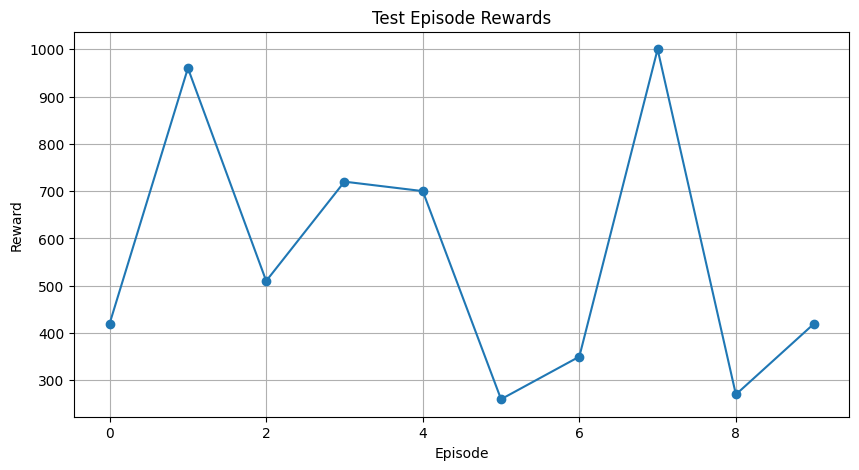

In [ ]:
import numpy as np
import tensorflow as tf
import gymnasium as gym
from collections import deque
from PIL import Image
import time
from IPython.display import display, clear_output
import matplotlib.pyplot as plt

# Load custom PPO model
class PPOPolicy(tf.keras.Model):
    def __init__(self, action_size, **kwargs):
        super(PPOPolicy, self).__init__(**kwargs)
        self.action_size = action_size
        self.conv1 = tf.keras.layers.Conv2D(32, (8, 8), strides=4, activation='relu')
        self.conv2 = tf.keras.layers.Conv2D(64, (4, 4), strides=2, activation='relu')
        self.conv3 = tf.keras.layers.Conv2D(64, (3, 3), strides=1, activation='relu')
        self.flatten = tf.keras.layers.Flatten()
        self.dense = tf.keras.layers.Dense(512, activation='relu')
        self.logits = tf.keras.layers.Dense(action_size, activation=None)

    def call(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.flatten(x)
        x = self.dense(x)
        return self.logits(x)

    def get_config(self):
        config = super().get_config()
        config.update({'action_size': self.action_size})
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)

# Frame preprocessing (for grayscale + stack)
def preprocess_frame(frame):
    frame = frame[1:176:2, ::2]  # Crop and downsample (88x80)
    frame = np.mean(frame, axis=-1) / 255.0  # Convert to grayscale and normalize
    return frame.astype(np.float32)

# Load PPO model from file
def load_model(model_path, action_size):
    try:
        model = PPOPolicy(action_size)
        model.build(input_shape=(None, 88, 80, 4))
        model.load_weights(model_path)
        print(f"Model loaded from {model_path}")
        return model
    except Exception as e:
        print(f"Failed to load model: {e}")
        raise

class PacManTester:
    def __init__(self, model_path, frame_stack_size=4, render=True):
        self.model = load_model(model_path, action_size=9)  # Adjust action size as needed
        self.env = gym.make(
            "ALE/MsPacman-v5",
            render_mode="rgb_array" if render else None
        )
        self.frame_stack_size = frame_stack_size
        self.action_size = self.env.action_space.n
        self.render = render

    def preprocess_frame(self, frame):
        frame = frame[1:176:2, ::2]  # Downsample to 88x80
        return np.mean(frame, axis=-1, dtype=np.float32) / 255.0

    def create_initial_state(self, frame):
        return np.stack([frame] * self.frame_stack_size, axis=-1)

    def update_state(self, state, new_frame):
        return np.concatenate([state[..., 1:], np.expand_dims(new_frame, axis=-1)], axis=-1)

    def run_episode(self, max_steps=10000, epsilon=0.0):
        frame, _ = self.env.reset()
        frame = self.preprocess_frame(frame)
        state = self.create_initial_state(frame)

        total_reward = 0
        frames = [] if self.render else None

        for step in range(max_steps):
            if np.random.random() < epsilon:
                action = self.env.action_space.sample()
            else:
                input_tensor = np.expand_dims(state, axis=0)
                logits = self.model(input_tensor)
                action = np.argmax(logits.numpy()[0])

            next_frame, reward, done, _, _ = self.env.step(action)
            next_frame = self.preprocess_frame(next_frame)
            state = self.update_state(state, next_frame)
            total_reward += reward

            if self.render:
                frames.append(self.env.render())

            if done:
                break

        print(f"Test Reward: {total_reward}")

        if self.render and frames:
            self._display_frames(frames)

        return total_reward

    def _display_frames(self, frames):
        display_handle = display(None, display_id=True)
        for frame in frames:
            display_handle.update(Image.fromarray(frame))
            time.sleep(0.03)  # Matches game speed
        clear_output(wait=True)

    def benchmark(self, num_episodes=10, epsilon=0.0):
        rewards = []
        for ep in range(num_episodes):
            reward = self.run_episode(epsilon=epsilon)
            rewards.append(reward)
            print(f"Episode {ep+1}/{num_episodes}: Reward = {reward}")

        print("\nBenchmark Results:")
        print(f"- Average: {np.mean(rewards):.1f}")
        print(f"- Best: {np.max(rewards)}")
        print(f"- Worst: {np.min(rewards)}")
        print(f"- Std Dev: {np.std(rewards):.1f}")

        plt.figure(figsize=(10, 5))
        plt.plot(rewards, marker='o')
        plt.title("Test Episode Rewards")
        plt.xlabel("Episode")
        plt.ylabel("Reward")
        plt.grid()
        plt.show()

        return rewards

if __name__ == "__main__":
    model_path = "/content/ppo_pacman_ep350.keras"  # Replace with actual model path
    tester = PacManTester(
        model_path=model_path,
        frame_stack_size=4,  # Same as during training
        render=True
    )

    # Run a single test episode with rendering
    print("Running single test episode...")
    test_reward = tester.run_episode(epsilon=0.3)

    # Optionally, run full benchmarking
    print("\nRunning benchmark with 10 episodes...")
    test_results = tester.benchmark(num_episodes=10,epsilon=0.4)


Episode 10/10: Reward = 1210.0

Benchmark Results:
- Average: 512.0
- Best: 1210.0
- Worst: 150.0
- Std Dev: 299.0


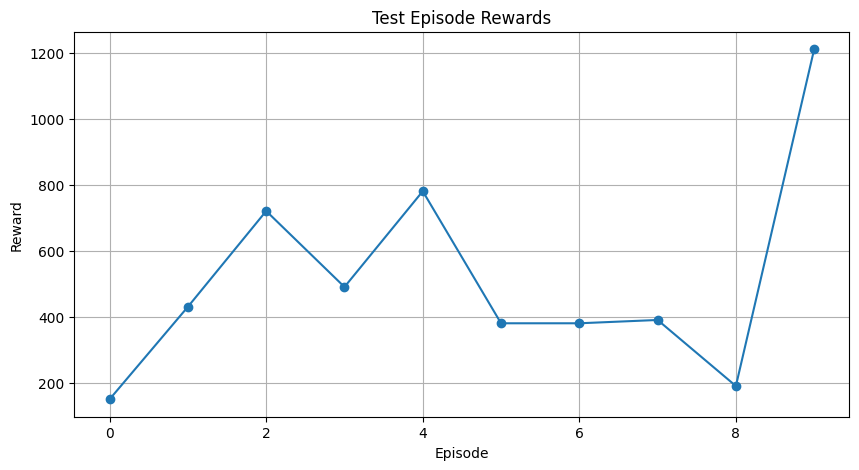

In [ ]:
if __name__ == "__main__":
    model_path = "/content/ppo_pacman_ep500.keras"  # Replace with actual model path
    tester = PacManTester(
        model_path=model_path,
        frame_stack_size=4,  # Same as during training
        render=True
    )

    # Run a single test episode with rendering
    print("Running single test episode...")
    test_reward = tester.run_episode(epsilon=0.3)

    # Optionally, run full benchmarking
    print("\nRunning benchmark with 10 episodes...")
    test_results = tester.benchmark(num_episodes=10, epsilon=0.4)